# Top 50 Analysis Using Boardgamegeek Data

## Imports and Helper Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import requests

from PIL import Image

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
db_loc = 'data/bgg_data.sqlite'

def query_db(statement):
    '''
    Run the given query against the local Sqlite database file, and return the results in a DataFrame.
    '''
    
    conn = sqlite3.connect(db_loc)
    try:
        df = pd.read_sql(statement, conn)
    finally:
        conn.close()
    return df

In [3]:
def plot_category_bar(df, col_name, n, title_col, figsize=(12, 8)):
    '''
    For the given DataFrame, plot a bar chart counting all instances for the given column,
    then plot a similar bar chart for the column for each name in the `person` column.
    '''
    
    df_count = df.groupby(col_name).size().reset_index(name='count').nlargest(n, 'count')
    labels = df[col_name].unique()

    # assign a color to each label value for consistency
    palette = dict(zip(labels, sns.color_palette(n_colors=len(labels))))

    # plot the chart for the total distribution
    f = plt.figure(1, figsize=figsize)
    f.suptitle(f'Total {title_col} distribution')
    sns.barplot(data=df_count, x=col_name, y='count', palette=palette)
    plt.xticks(rotation=90)

    users = df['person'].unique()

    df_count = df.groupby(['person', col_name]).size().reset_index(name='count')

    # we can't guarantee that the labels match for each user
    # therefore, plot a new chart for each user
    fig_count = 2
    for user in users:
        f = plt.figure(fig_count, figsize=figsize)
        user_count = df_count[df_count['person'] == user].nlargest(n, 'count')
        sns.barplot(data=user_count, x=col_name, y='count', palette=palette)
        plt.xticks(rotation=90)
        f.suptitle(f'{user} {title_col} distribution')
        fig_count += 1
    plt.show()

In [4]:
def download_image(url):
    '''Download the image from the given URL, then return it in an Image object.'''
    r = requests.get(url, stream=True)
    im = Image.open(r.raw)
    return im

# The Top 50 Lists

In [5]:
user_ranks = query_db(
"""
select user_ranks.name as person, user_ranks.rank, games.*
from user_ranks
inner join games
    on user_ranks.game_id = games.id
""")

games = query_db('select * from games')

## Top 10
Of all the games in a top 50 list, the most important are the top 10. They are the best of the best, the cream of the crop. Therefore, we give them special precedence here by making a nice display of their cover art.

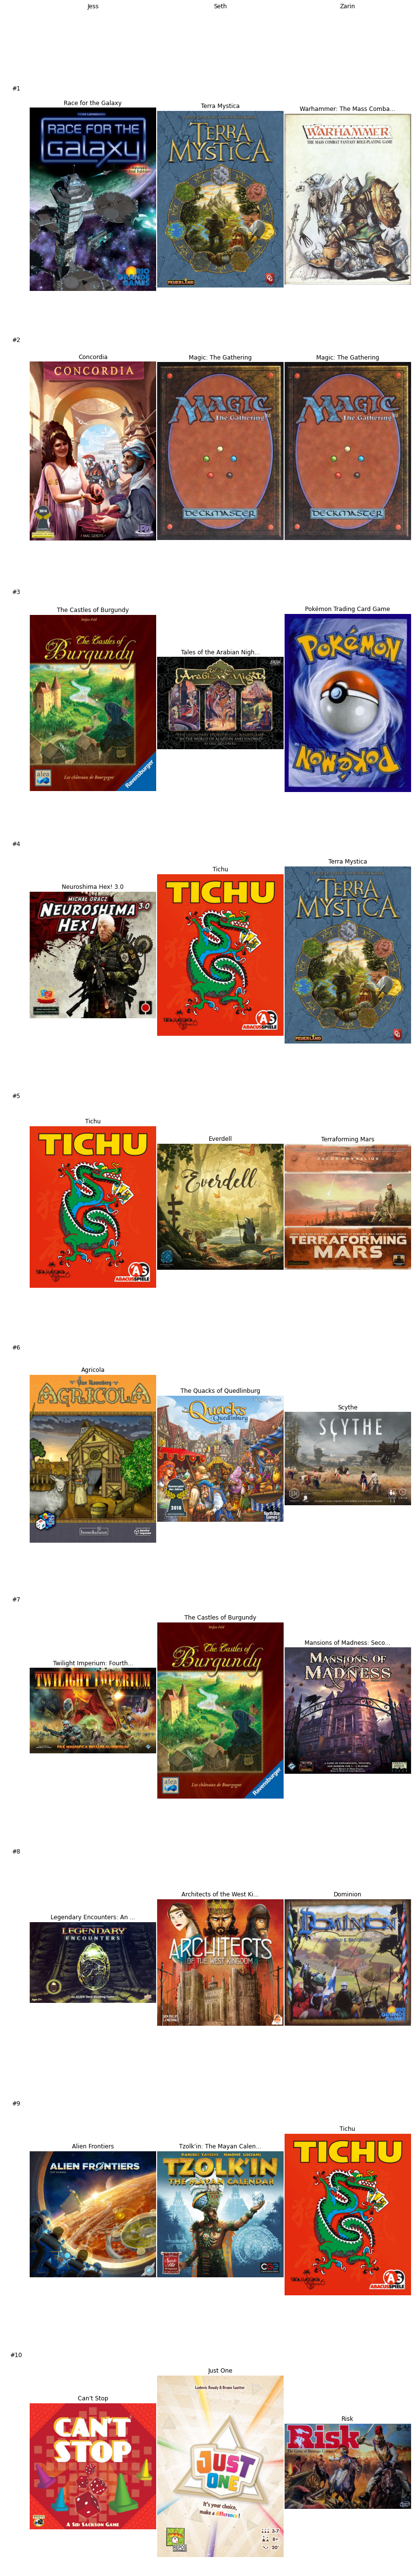

In [30]:
top10 = user_ranks[user_ranks['rank'] <= 10]

users = list(top10['person'].unique())
cols = len(users) + 1
rows = 10 + 1

gridspec = {
    'width_ratios': [1] + ([5] * len(users)), # [1, 5, 5, ...] one 5 per user
    'height_ratios': [1] + ([5] * (rows-1)), # [1, 5, 5, ...] one 5 per 50 games,
    'wspace': 0.01
}
fig, axes = plt.subplots(rows, cols, figsize=(15, 15), gridspec_kw=gridspec)
fig.tight_layout(pad=10.0)
plt.subplots_adjust(top=5)

# top left corner
axes[0, 0].axis('off')

# header row
row_idx = 1
for user in users:
    ax = axes[0, row_idx]
    ax.set_title(user)
    ax.axis('off')
    row_idx += 1

# top 50 list rows
for rank, group in top10.groupby('rank'):
    # ranking number display
    ax = axes[rank, 0]
    ax.set_title(f'#{rank}')
    ax.axis('off')
    
    # games per user
    row_idx = 1
    for user in users:
        row = group[group['person'] == user]
        
        url = row['img_url'].item()
        title = row['name'].item()
        title = (title[:25] + '...') if len(title) > 25 else title
        img = download_image(url)
        
        ax = axes[rank, row_idx]
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
        
        row_idx += 1
        
plt.show()

## The Full Lists

In [92]:
user_ranks[['person', 'name', 'rank']].pivot(index='rank', columns='person')

name  \
person                                               Jess   
rank                                                        
1                                     Race for the Galaxy   
2                                               Concordia   
3                                 The Castles of Burgundy   
4                                     Neuroshima Hex! 3.0   
5                                                   Tichu   
6                                                Agricola   
7                       Twilight Imperium: Fourth Edition   
8       Legendary Encounters: An Alien Deck Building Game   
9                                         Alien Frontiers   
10                                             Can't Stop   
11                                               Pandemic   
12                                      Terraforming Mars   
13                                                   Hive   
14                                            Carcassonne   
15                                               Camel Up   
16                                               Wingspan   
17                                               For Sale   
18                                             Memoir '44   
19                                 Mage Knight Board Game   
20                                       Cosmic Encounter   
21                                                 Hanabi   
22                              Pandemic Legacy: Season 1   
23                                                 Blokus   
24                                               San Juan   
25                                 The Resistance: Avalon   
26                  Roll Through the Ages: The Bronze Age   
27                               Flash Point: Fire Rescue   
28                                             Wavelength   
29                                  Sheriff of Nottingham   
30                                                  Skull   
31                                            Core Worlds   
32                                               Dominion   
33                                            Puerto Rico   
34                                          King of Tokyo   
35                                                 Tobago   
36                                             No Thanks!   
37                                            Lost Cities   
38                                          Telestrations   
39                   Exit: The Game – The Abandoned Cabin   
40                                                  Dixit   
41                                                Onitama   
42                                              Patchwork   
43                               Diamonds: Second Edition   
44                                              7 Wonders   
45                                           The Grizzled   
46                                             Power Grid   
47                                                     K2   
48                                            Battle Line   
49                                         Galaxy Trucker   
50                                                 Perudo   

                                                           \
person                                               Seth   
rank                                                        
1                                           Terra Mystica   
2                                    Magic: The Gathering   
3                             Tales of the Arabian Nights   
4                                                   Tichu   
5                                                Everdell   
6                               The Quacks of Quedlinburg   
7                                 The Castles of Burgundy   
8                          Architects of the West Kingdom   
9                            Tzolk'in: The Mayan Calendar   
10                                               Just One   
11                        

## Game Crossovers

In this section, we check how many games appeared on multiple individual's lists. Each listed grouping shows the games that only they had in common. That is, if a game is shared by three people, it will not show up in the group for any of the pairs.

----------------------------------------------------------------------------------------------------
Crossovers exclusive to Jess & Seth


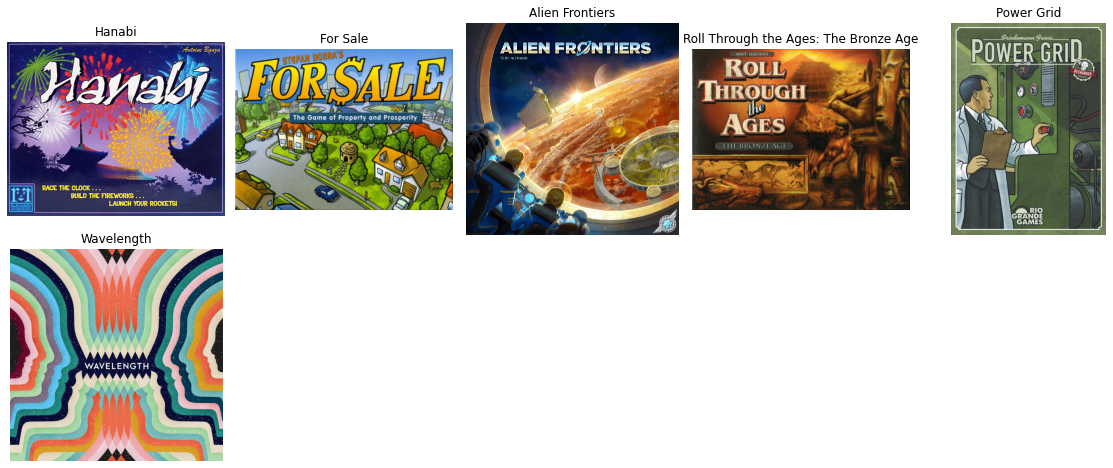

----------------------------------------------------------------------------------------------------
Crossovers exclusive to Jess & Seth & Zarin


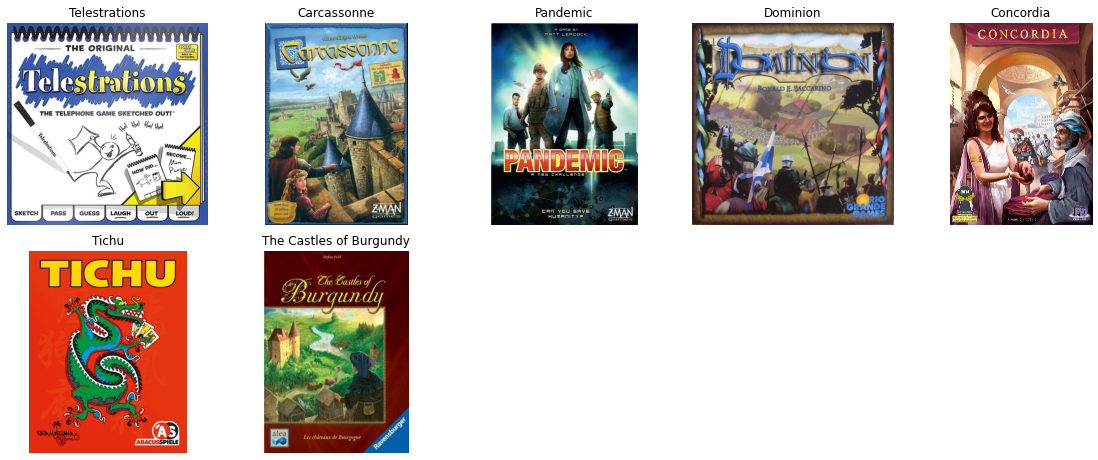

----------------------------------------------------------------------------------------------------
Crossovers exclusive to Jess & Zarin


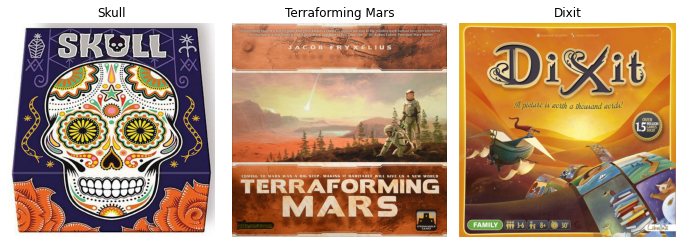

----------------------------------------------------------------------------------------------------
Crossovers exclusive to Seth & Zarin


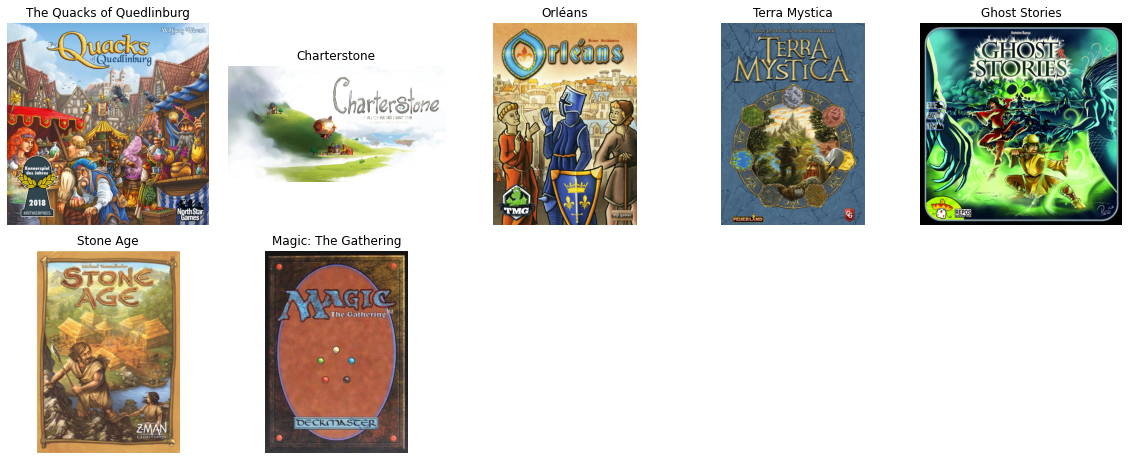

In [19]:
# find every game with more than one person having it in their list
# join the users with commas
cross = user_ranks[['person', 'id']].groupby('id')['person'].apply(','.join).reset_index(name='people')

# get the count by counting the commas + 1 (e.g. "Person1,Person2" -> 2)
cross['count'] = cross['people'].str.count(',') + 1

# filter games to include only ones with crossover
cross = cross[cross['count'] > 1].sort_values('count', ascending=False)

# join with the games DataFrame to get the name
cross = pd.merge(cross, games, how='inner', on=['id', 'id'])

# display the images for each group
# todo: order this by number in the group (i.e. show crossover between group before pair)
for users, group in cross.groupby('people'):
    users = users.split(',')
    print('-' * 100)
    print('Crossovers exclusive to %s' % ' & '.join(users))
    
    urls = list(group['img_url'])
    titles = list(group['name'])

    # set width / height for the image grid
    # note: a maximum of 25 images will be shown (not anticipating more than that anyway)
    width = 5
    height = 5
    axes = []
    fig = plt.figure(figsize=(16,16))
    
    for a in range(min(len(urls), width * height)):
        axes.append(fig.add_subplot(height, width, a+1))
        url = urls[a]
        title = titles[a]
        img = download_image(url)
        plt.imshow(img)
        axes[-1].set_title(title)
        plt.axis('off')
    fig.tight_layout()
    plt.show()

# Game Statistics

In [55]:
user_ranks = query_db(
"""
select user_ranks.name as person, user_ranks.rank, games.*
from user_ranks
inner join games
    on user_ranks.game_id = games.id
""")

user_ranks['bgg_rank'] = user_ranks['bgg_rank'].astype(int)

## Comparing individual rankings against BGG rankings

In the following section, we compare each individual's ranking for a game against its ranking on Boardgamegeek. Because significant outliers in Boardgamegeek ranking can adversely affect the charts, we ignore any that are above the rank 2000. Omitting these games *should* have only a small effect on the results.

In [56]:
MAX_BGG_RANK = 2000

rankings_in_range = user_ranks[user_ranks['bgg_rank'] < MAX_BGG_RANK]
over_2000 = user_ranks[user_ranks['bgg_rank'] >= MAX_BGG_RANK]

if not over_2000.empty:
    print('Ignoring %d element(s) with BGG rank > 2000:' % len(over_2000))
    print(over_2000[['person', 'name', 'bgg_rank']])

Ignoring 4 element(s) with BGG rank > 2000:
    person                       name  bgg_rank
81    Seth                Catchphrase      9252
102  Zarin  Pokémon Trading Card Game      2578
109  Zarin                       Risk     19446
120  Zarin                  Black Spy      4369


Here we plot each individual's rankings against each game's Boardgamegeek ranking. The more closely the points resemble a straight line, the more the individual's rankings match up with those on Boardgamegeek. The charts include a best fit line and a highlighted confidence interval. A larger confidence interval indicates that the rankings do not closely match the relative ordering for the games' BGG rankings.  

The confidence intervals shown should be taken with a grain of salt, because they are greatly affected by outliers, which were removed to make these charts readable. 

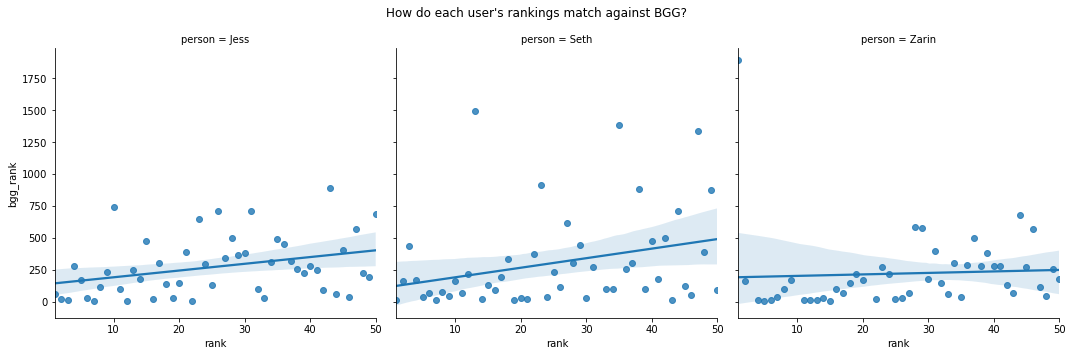

In [57]:
sns.lmplot(x='rank', y='bgg_rank', data=rankings_in_range, col='person')
plt.suptitle("How do each user's rankings match against BGG?")
plt.tight_layout()
plt.show()

Here we see a box and whisker chart, showing the median and quartile ranges, as well as any outliers.  

Seth and Zarin both have much larger clusters of games near the top of the BGG leaderboards than Jess, but also have more games far away from the top (and the dropped outliers would make this even more clear). With the outliers, the shape of the plots for Seth and Zarin would likely look much more similar.  

Jess's choices all exist within the top 1000, and are fairly well distributed within the top ~400 games on Boardgamegeek. 

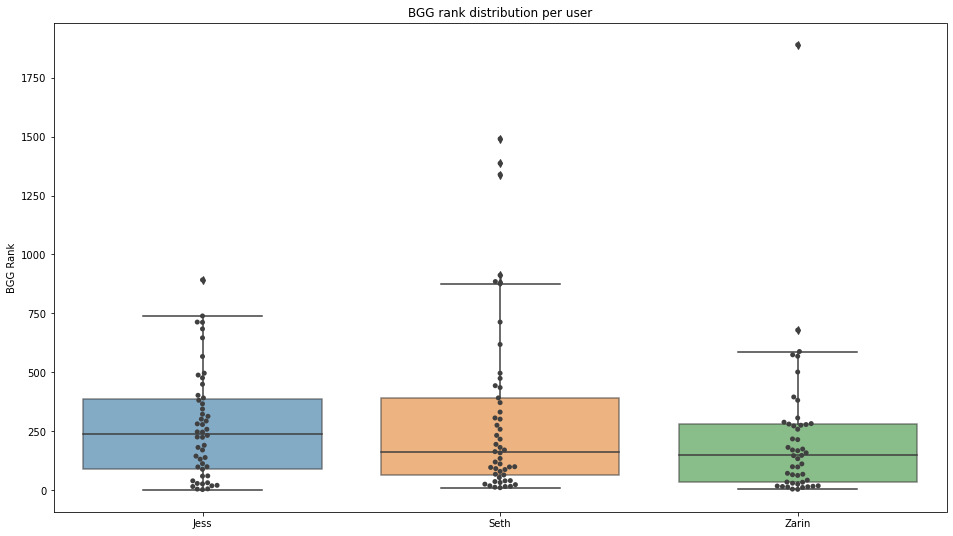

In [58]:
plt.figure(figsize=(16, 9))
plt.title('BGG rank distribution per user')
sns.boxplot(x='person', y='bgg_rank', data=rankings_in_range, boxprops=dict(alpha=0.6))
sns.swarmplot(x='person', y='bgg_rank', data=rankings_in_range, color='0.25')
plt.ylabel('BGG Rank')
plt.xlabel('')
plt.show()

Finally, we have a breakdown of how many games were in different ranges of BGG rankings. The total ranking distribution does include multiple instances of the same game if there is crossover. Because of this, these charts should be seen as "how many game rankings were in this range?", rather than "how many games were in this range?".  

Repeating the similarity seen above, Seth and Zarin have the exact same breakdown in ranking distribution. Jess does not have the same large amount of games from the top 100, instead having far more in the 100-500 range.

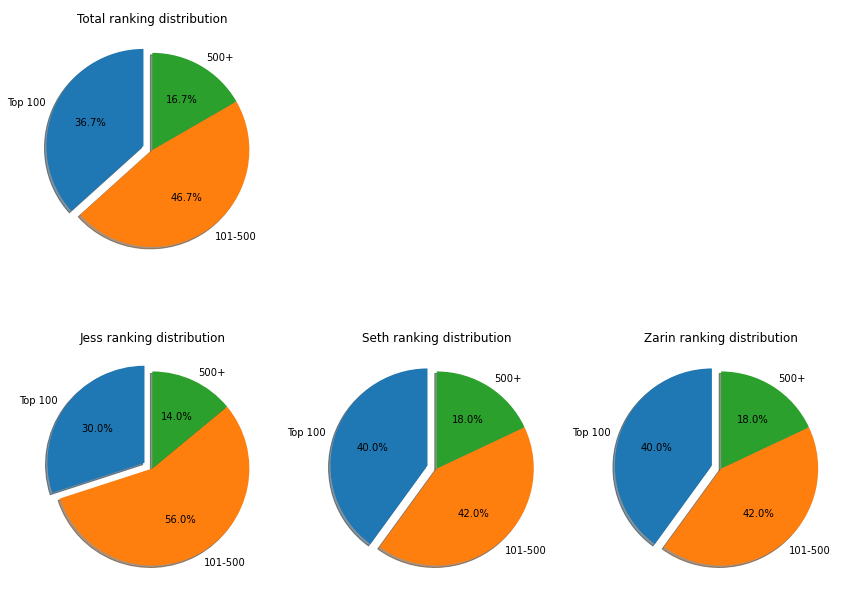

In [62]:
top_100 = user_ranks[['person', 'bgg_rank']]
top_100['rank'] = pd.cut(top_100['bgg_rank'], bins=[0, 100, 500, np.inf], labels=['Top 100', '101-500', '500+'])
top_100 = top_100.groupby(['person', 'rank']).size().unstack(fill_value=0)

labels = top_100.columns

# pull out the pie portion for top 100
explode = [0.1 if col == 'Top 100' else 0 for col in labels]

fig, axes = plt.subplots(2, len(top_100.index), figsize=(12, 9))
fig.tight_layout()

# zero out upper row
axes[0, 1].axis('off')
axes[0, 2].axis('off')

# set upper left corner to show total distribution
axes[0, 0].set_title('Total ranking distribution')
axes[0, 0].pie(top_100.sum(), labels=labels, explode=explode, autopct='%1.1f%%', startangle=90, shadow=True)

# set second row to show individual distributions
fig_count = 0
for i in top_100.index:
    axes[1, fig_count].set_title(f'{i} ranking distribution')
    axes[1, fig_count].pie(top_100.loc[i], labels=labels, explode=explode, autopct='%1.1f%%', startangle=90, shadow=True)
    
    fig_count += 1

## Game weights

In this section we look at Boardgamegeek's "weight" for the selected games. The values range from 1 to 5, with more complex games scoring higher.  

In the violin plots below, we can see the mean and quartile ranges as in the box and whisker plot, as well as the distribution of the data around that weight, shown as the width of the plot.

Jess's top 50 list has a marked focus on the lower end of the weight spectrum, with only a handful of games having a weight over ~3.5. In addition, he has the lowest mean, and by far the lowest 1st quartile. Interestingly, he also has the two selected games with the highest weights (Mage Knight and TI4, respectively).

Seth's games are much more tightly clustered around the mean than either Jess or Zarin, and his mean is fairly high as well.

Zarin has a fairly even spread over the entire spectrum of weights, with no clear outliers.

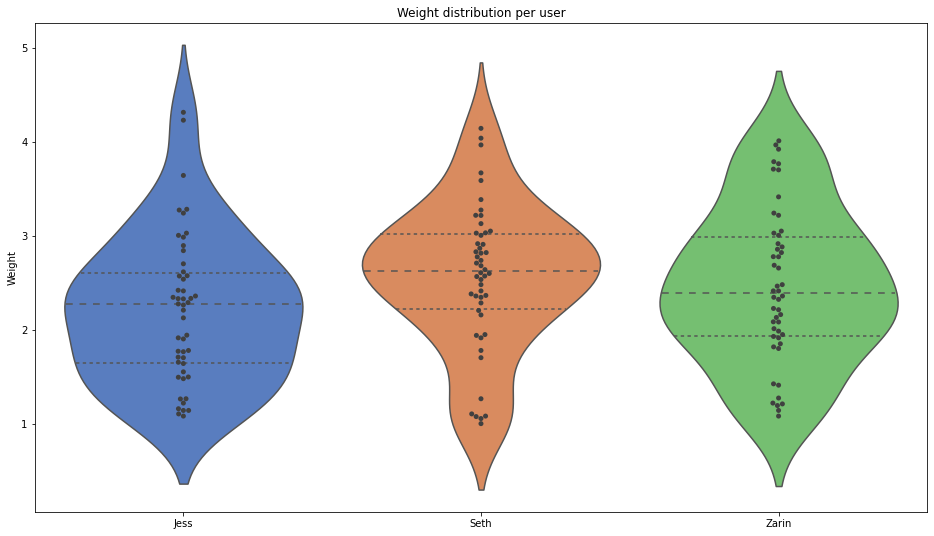

In [63]:
plt.figure(figsize=(16, 9))
plt.title('Weight distribution per user')
ax = sns.violinplot(x='person', y='weight', data=user_ranks, inner='quartile', scale='count', palette='muted')
sns.swarmplot(x='person', y='weight', data=user_ranks, color='0.25')
plt.ylabel('Weight')
plt.xlabel('')
plt.show()

## Player counts

In this section we will investigate the best player counts for games. Each game can support a certain number of players, and users on Boardgamegeek can vote "Best", "Recommended", and "Not Recommended" for each player count. Because a game may have multiple "best" player counts, we only consider the player count with the most "Best" votes as being the best for the purposes of this analysis.  

Unsurprisingly, each person has a similar distribution of player counts. Four player games have a clear spike, but this should be expected because board games tend to be designed around four players.

<Figure size 1152x1152 with 0 Axes>

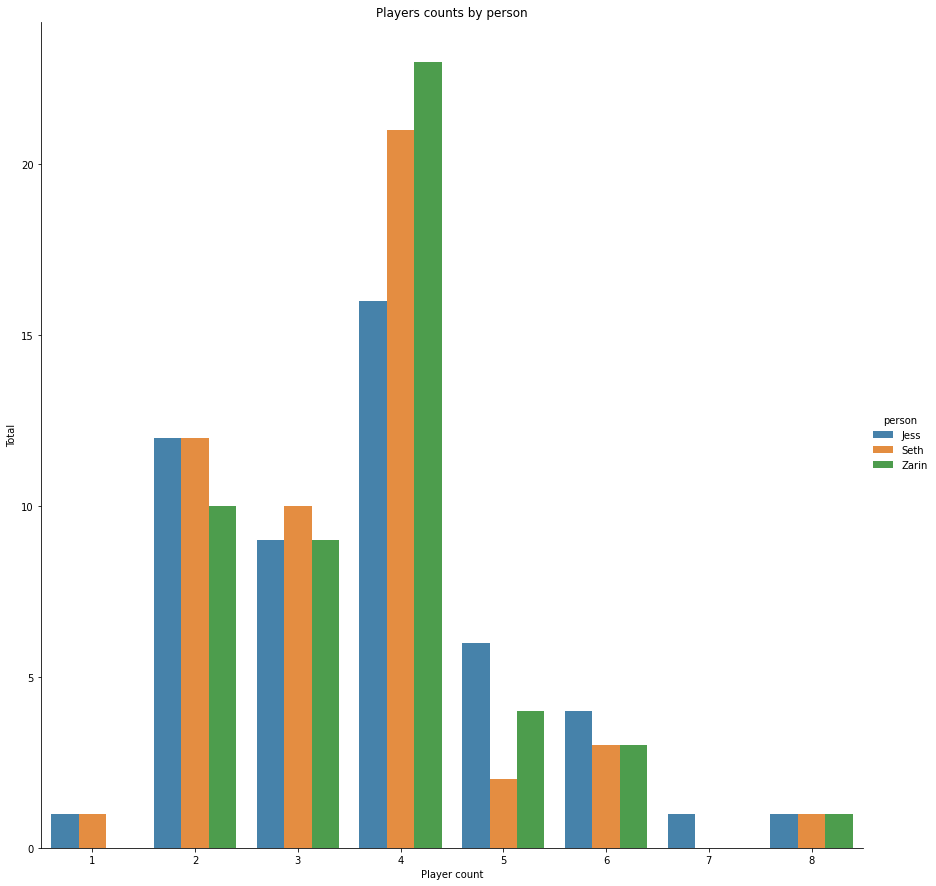

In [83]:
plt.figure(figsize=(16, 16))
counts_by_user = user_ranks.groupby(['person', 'best_count']).size().reset_index(name='count')
sns.catplot(data=counts_by_user, kind='bar', x='best_count', y='count', hue='person', alpha=0.9, height=12)
plt.title('Players counts by person')
plt.xlabel('Player count')
plt.ylabel('Total')
plt.show()

## Release Year

In this section, we investigate how each person's game selections break down by release dates. With such a wide range of possible dates, each chart only shows games from 1980 to today (selected semi-arbitrarily), but the omitted years for each individual are printed out above the charts.  

Unsurprisingly, most games in these lists were released relatively recently, beginning to spike around the same time everyone was old enough to be able to pay for games. 😏  

We can see that there are few games released from the last couple of years making it on the list, probably because they haven't been played enough to justify a spot yet.

Note - not including games for Jess from the following years for readability:
 - 1800
Note - not including games for Seth from the following years for readability:
 - 1974
Note - not including games for Zarin from the following years for readability:
 - 1959


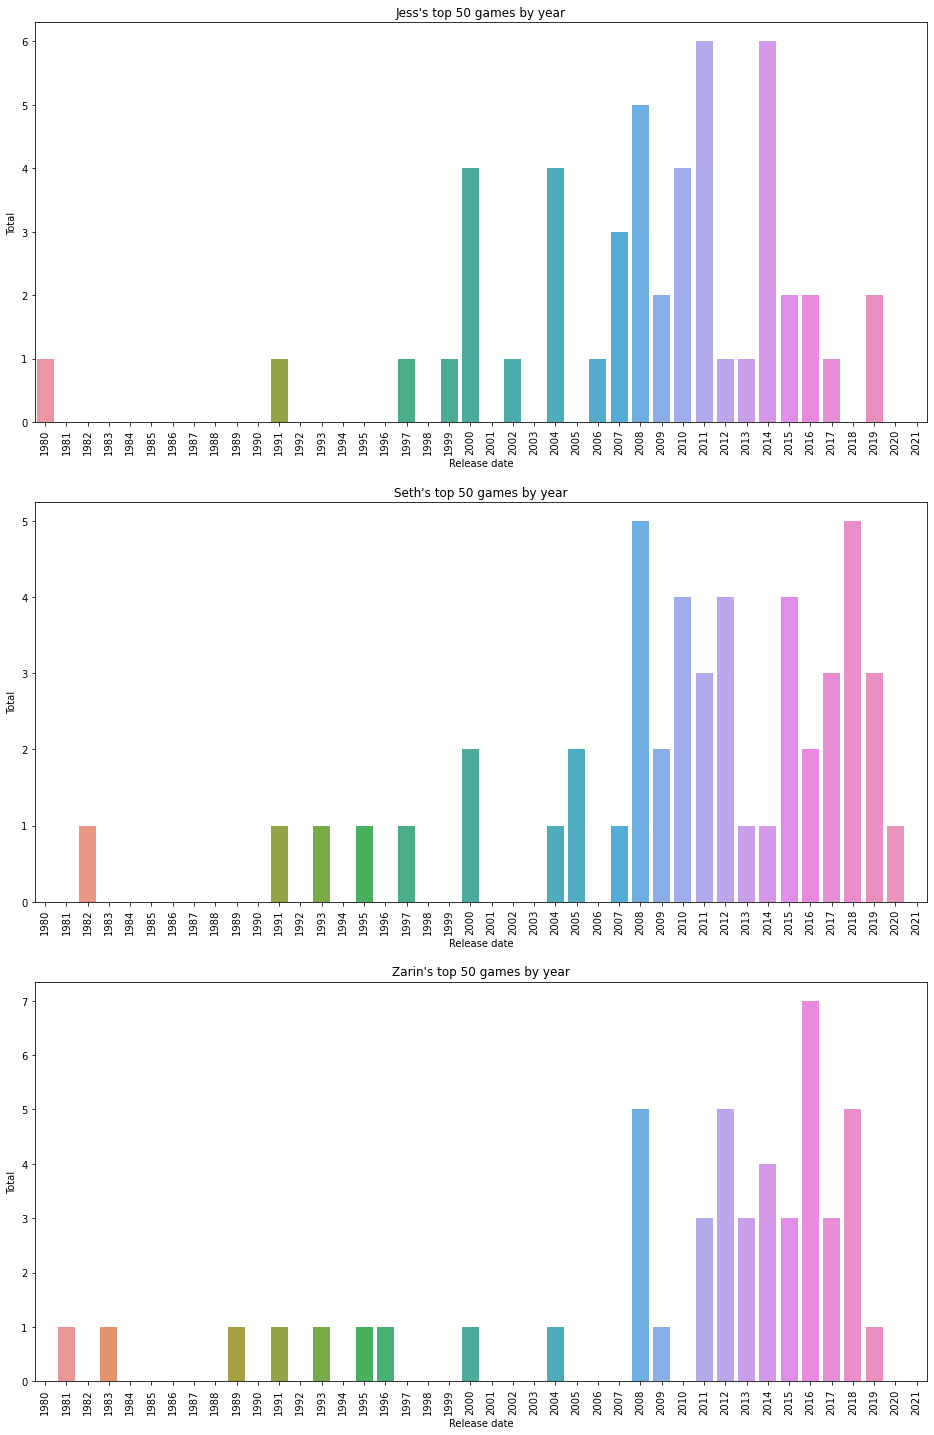

<Figure size 432x288 with 0 Axes>

In [107]:
MIN_YEAR = 1980
MAX_YEAR = 2021

users = user_ranks['person'].unique()

fig, axes = plt.subplots(nrows=len(users), ncols=1, figsize=(16, 25))

index = 0

for user in users:
    # get the games for this person, group them by year and count them
    by_year = user_ranks[user_ranks['person'] == user].groupby('year').size().reset_index(name='count')
    
    # do we have any that are below the minimum year? 
    # if so, print them out with a nice little note
    below_limit = by_year[by_year['year'] < MIN_YEAR]['year'].unique()
    if below_limit:
        print(f'Note - not including games for {user} from the following years for readability:')
        for year in below_limit:
            print(f' - {year}')
           
    # filter to recent years to make the graph readable
    by_year = by_year[by_year['year'] >= MIN_YEAR]
    
    # add values for missing years to spread out the bars
    for year in range(MIN_YEAR, MAX_YEAR+1):
        if year not in by_year['year'].values:
            by_year = by_year.append({'year': year, 'count': 0}, ignore_index=True)
    
    barplot = sns.barplot(data=by_year, x='year', y='count', ax=axes[index])
    barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90, horizontalalignment='center')
    axes[index].set_title(f"{user}'s top 50 games by year")
    axes[index].set_ylabel('Total')
    axes[index].set_xlabel('Release date')
    
    index += 1
plt.show()
plt.tight_layout()

## User Rating Counts

We can also evaluate each individual's list by their relative popularity by using the game's number of ratings on Boardgamegee. Games with a low number of ratings will likely either be unpopular games or very new games, so we can use this metric to determine which individual has the most "underground" or "cult of the new" list.

First, let's look at the ten game selections with the lowest number of ratings. Right off the bat, we can see a couple problems. *Catchphrase*, *Warhammer*, and the *Pokémon TCG* are all very popular games, but BGG users likely don't feel the need to rate them on the site. Therefore, take the results from this section with a grain of salt.

In [123]:
low_counts = user_ranks.sort_values('users_rated', ascending=True)
low_counts = low_counts[['person', 'name', 'year', 'users_rated']]
low_counts.head(10)

person                                               name  year  \
81    Seth                                        Catchphrase  1974   
120  Zarin                                          Black Spy  1981   
62    Seth                                         Honey Buzz  2020   
84    Seth                                The Artemis Project  2019   
143  Zarin                   In the Hall of the Mountain King  2019   
72    Seth                                          Automania  2015   
100  Zarin  Warhammer: The Mass Combat Fantasy Roleplaying...  1983   
102  Zarin                          Pokémon Trading Card Game  1996   
27    Jess                                         Wavelength  2019   
91    Seth                                         Wavelength  2019   

     users_rated  
81           178  
120          627  
62           766  
84          1264  
143         1997  
72          2166  
100         2406  
102         3441  
27          3645  
91          3645

Here we see a plot of the popularity distribution for each user. Right at the top, we see a large cluster of seemingly identical outliers. These points correspond to the "gateway games" in the lists with a lot of crossover, such as *Carcassonne*, *Dominion*, and *Pandemic*. Clearly, Seth has the most underground list in the group. The spread or popularity in his list is far lower than that of either Jess or Zarin.

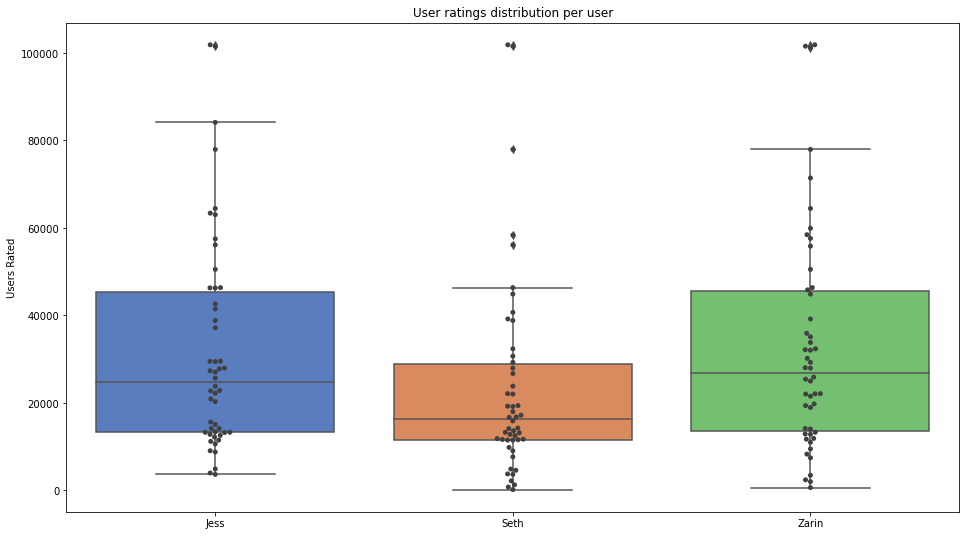

In [121]:
plt.figure(figsize=(16, 9))
plt.title('User ratings distribution per user')
ax = sns.boxplot(x='person', y='users_rated', data=user_ranks, palette='muted')
sns.swarmplot(x='person', y='users_rated', data=user_ranks, color='0.25')
plt.ylabel('Users Rated')
plt.xlabel('')
plt.show()

# Game Mechanics Statistics

On Boardgamegeek, every game is labeled with a set of mechanics, such as "card drafting" or "worker placement". In this section, we look at how each person's selections are distributed with respect to these mechanics.

Note that every game can have a large number of listed mechanics. For example, a simple game like *No Thanks!* has five associated mechanisms, and a complex game like "Twilight Imperium 4" lists twelve. Because of this disparity, this analysis becomes biased toward more complex games, as they will tend to have more mechanics. In addition, some of the mechanics are so generic as to describe just about anything in a board game. Taking the top `n` mechanics for a game was discussed, but it turns out that this is not a valid approach. As an example, the top two mechanics listed for *Ticket To Ride* are "Card Drafting" and "End Game Bonuses". These are mechanisms present in the game, but a better description would probably come from the 3rd, 4th, and 6th in the list, "Hand Management", "Network and Route Building", and "Set Collection". Therefore, all mechanics for a game are included in the analysis.

In [29]:
mechanics = query_db(
"""
select user_ranks.name as person, games.name, mechanics.mechanic
from user_ranks
inner join games
    on user_ranks.game_id = games.id
inner join mechanics
    on games.id = mechanics.game_id
""")

Below, we chart the 10 mechanics that appear the most overall, as well as the mechanic distribution for each individual. As above with the BGG ranking distributions, the total distribution *does* count games multiple times. Loosely, this means that the total chart should be interpreted as answering the question "how many game selections were made with this mechanic?"  

The charts all have high counts for mechanics like "Hand Management" and "Dice Rolling", but this information is all but useless to us, because just about every game that includes cards or dice requires you to manage those cards or roll the dice.  

Jess's rankings show a significant spike in games with the "Hand Management" mechanism, however, showing up nearly twice as often as the next mechanism. This is very likely due to the high number of pure card games in his list. We also see the only instance of "Grid Movement" among his top mechanics.  

Seth's distribution tends to match the overall distribution fairly closely. Notably, "Worker Placement" only shows up on his top mechanics, taking 13 out of 19 of all "Worker Placement" rankings.  

Zarin's mechanics are far more evenly distributed than either Jess or Seth. It might be interesting to note that "Hand Management" shows up lower than expected, especially compared to the others. We also see a holy trifecta of replayability: "Variable Player Powers", "Modular Board", and "Variable Set-Up", only the first of which shows up on the other lists.

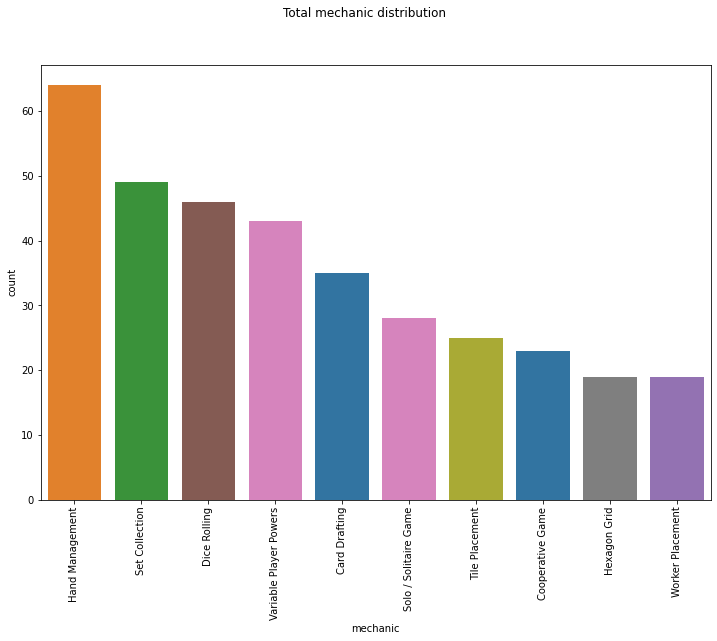

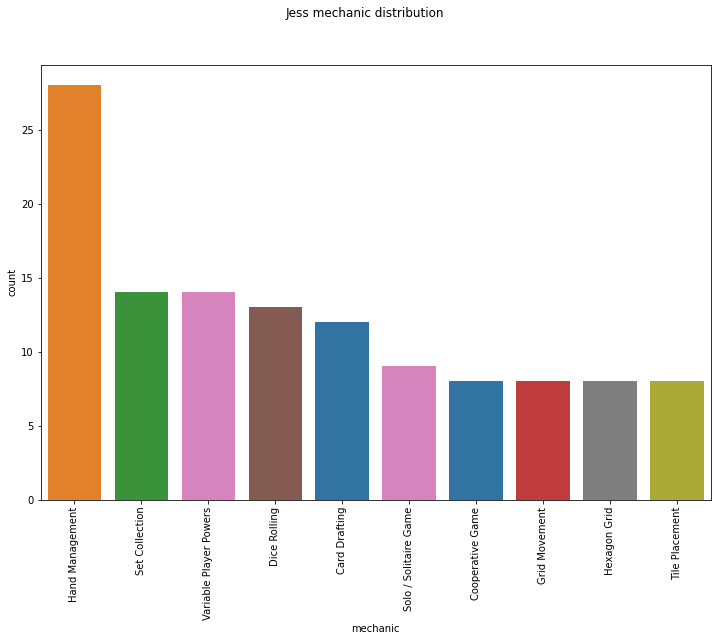

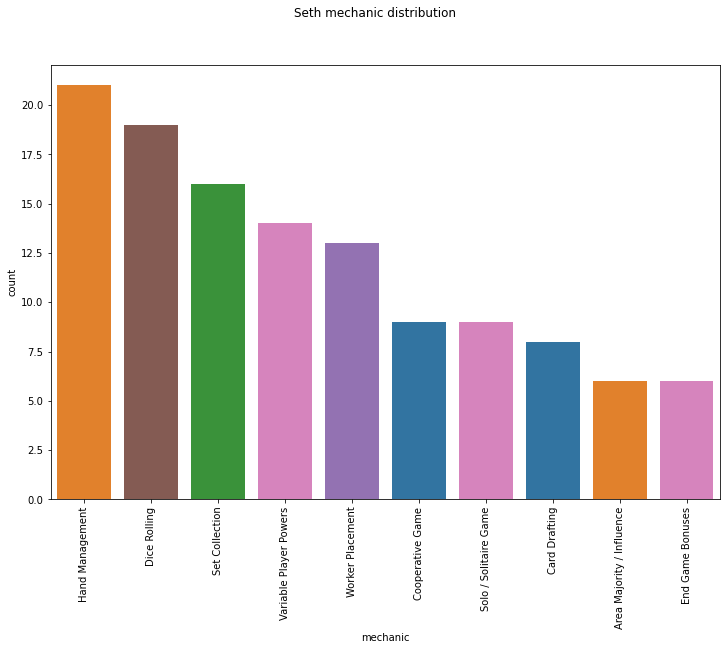

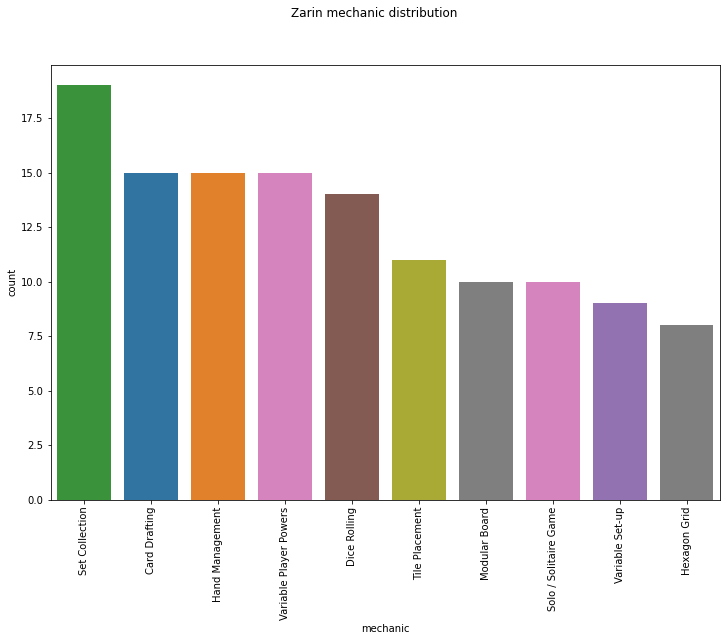

In [31]:
plot_category_bar(mechanics, 'mechanic', title_col='mechanic', n=10)

# Game Families Statistics

In this section, we analyze statistics about each game's "family". On Boardgamegeek, a family can refer to a high-level mechanism (e.g. 4X), certain types of components (e.g. miniatures), or many other groupings. Looking at the families overall will not give useful information, so each subfamily will be looked at individually below.

In [48]:
families = query_db(
"""
select user_ranks.name as person, games.name, families.family
from user_ranks
inner join games
    on user_ranks.game_id = games.id
inner join families
    on games.id = families.game_id
""")

## Kickstarter

The board game community has wholeheartedly embraced Kickstarter, for better or worse. The "Crowdfunding: Kickstarter" family notes a game that has been released on the platform. Here we ask the simple question? Which person has the most Kickstarter games on their list?

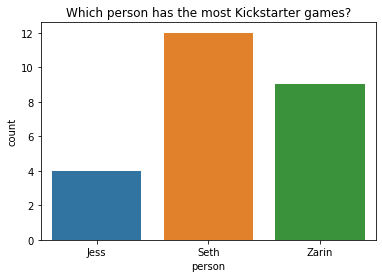

In [45]:
kickstarter_count = families.groupby(['person', 'family']).size().reset_index(name='count')
kickstarter_count = kickstarter_count[kickstarter_count['family'].str.contains('Kickstarter')]
sns.barplot(x='person', y='count', data=kickstarter_count)
plt.title('Which person has the most Kickstarter games?')
plt.show()

## Component Family

The "Component:" family is used to categorize the physical construction of the game, and how they are used.  

Each person seems to have one component that dominates their lists. For Jess, his large number of lighter games means card- and dice-focused components have the highest count. Seth has the largest disparity between the highest and second highest component counts, because he apparently loves maps. Zarin's top component is miniatures, which should be of no surprise after seeing his top 10.

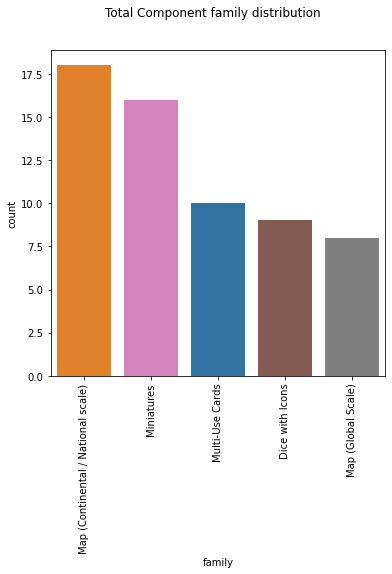

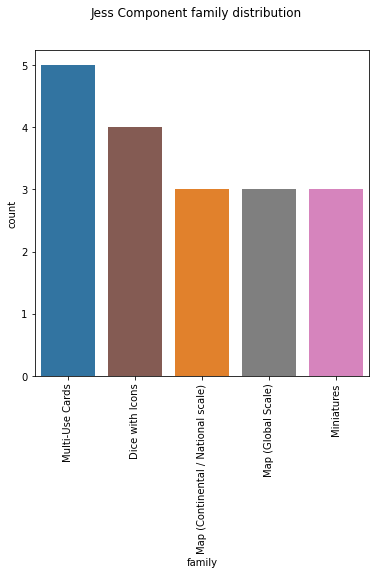

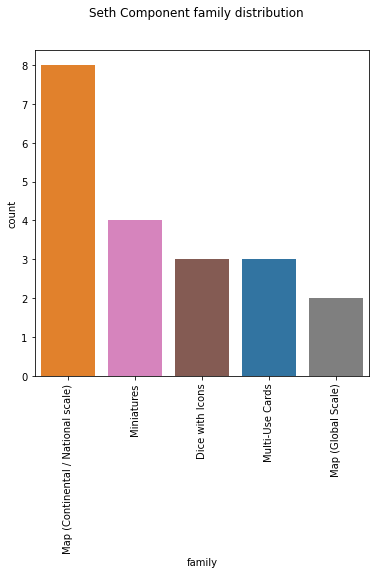

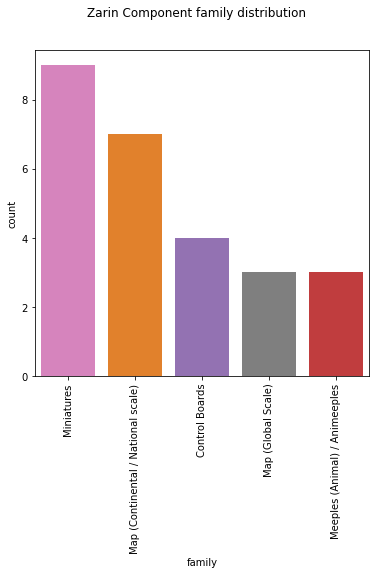

In [57]:
component_family = families[families['family'].str.startswith('Components')]

# remove 'Components: ' from the start of the family name
component_family['family'] = component_family['family'].str.replace('Components: ', '')
plot_category_bar(component_family, col_name='family', n=5, title_col='Component family', figsize=(6, 6))

# Game Category Statistics

On Boardgamegeek, a game can be be assigned a set of categories that define the game at a high-level. These categories may describe the overall theme of the game (e.g. *Pandemic* falls under the "Medical" category), or they may describe what kind of a game it is (e.g. *The Resistance* is in the "Party Game" category).

In [68]:
categories = query_db(
"""
select user_ranks.name as person, games.name, categories.category
from user_ranks
inner join games
    on user_ranks.game_id = games.id
inner join categories
    on games.id = categories.game_id
""")

The counts in this section are by request, not by game. To reiterate what has been said already in earlier sections, the overall chart should be seen as answering the question "how many selected games fall under this category?"

Overall, we can see that the vast majority of selections fall under the "Card Game" and "Economic" categories. This total category breakdown has few surprises other than that.  

It has been mentioned many times previously, but Jess's list is heavily dominated by card games, and that fact is made very clear here. There are nearly twice as many in the "Card Game" category as the next instances. Shocking no one, the "Science Fiction" and "Space Exploration" categories rank very highly, outnumbering both Seth and Zarin combined (10 vs 6 and 3, respectively).  

(Sorry Seth, I don't have much to say about your chart here. Maybe you need to pick more interesting games.)

Zarin clearly prefers fantasy games, that much is clear. Another interesting point is that Zarin has more games in the "Territory Building" category than both Jess and Seth combined (10 vs 4 and 4, respectively).

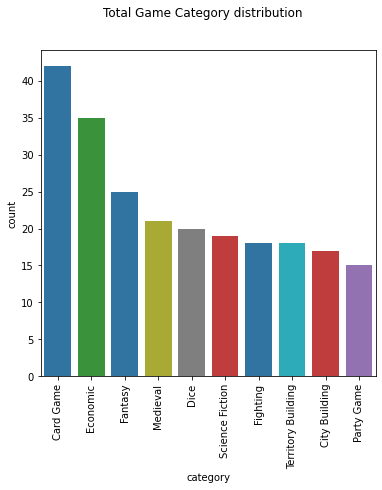

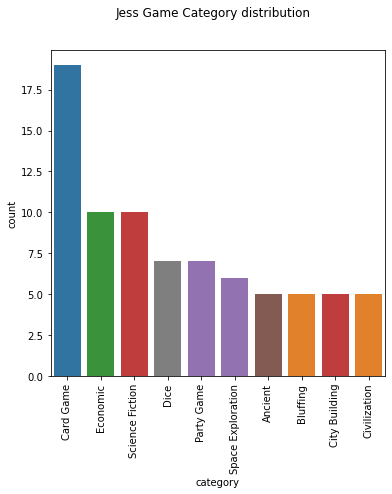

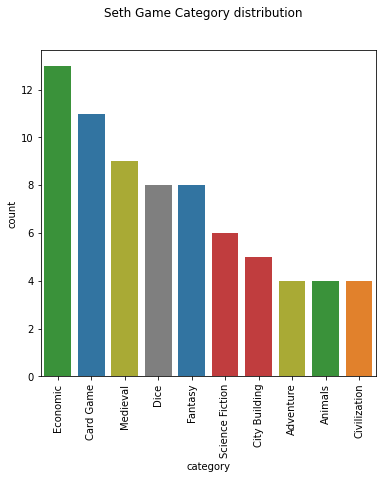

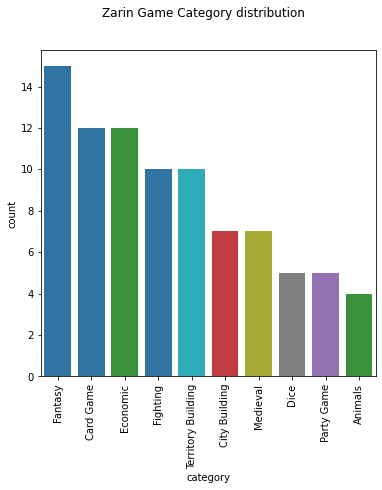

In [69]:
plot_category_bar(categories, col_name='category', n=10, title_col='Game Category', figsize=(6, 6))